<a href="https://colab.research.google.com/github/Alyona-Babko/AnDan_Sales/blob/main/%D0%9F%D1%80%D0%BE%D0%BC%D0%B5%D0%B6%D1%83%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B9_%D0%BA%D0%BE%D0%BD%D1%82%D1%80%D0%BE%D0%BB%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тема проекта

Зависимостей между продажами товаров в магазинах сети "Favorita" в Эквадоре и ценами на нефть марки "dcoilwtico".

Временной диапазон: 2013.01.01 - 2017.08.31

Источник: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Проект по АД/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Проект по АД


In [3]:
import pandas as pd
import numpy as np
import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import plotly.express as px

# Описание первоначальных данных

В нашей проекте мы будем использовать уже готовые таблицы с данными формата csv. Ниже приводится описание каждого датасета. Так как есть файлы, которые весят больше 300 МБ, было решено все файлы переместить в папочку на Goodle Диск.(ссылка: https://drive.google.com/drive/folders/13d8y2VSm3WI7CkY3el2E_AxfoZaJK6DK?usp=sharing)

## Описание полученных данных train и test (по столбцам):


In [4]:
df = pd.read_csv('train.csv')
df.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [5]:
test = pd.read_csv('test.csv')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


1. **id** - порядковый номер скрочки (дублирует номер строки, поэтому при обработке, данный столбец будет удалён)
2. **date** - дата продаж
3. **store_nbr** - порядковый номер магазина
4. **family** - класс продаваемых товаров
5. **onpromotion** - количество товаров, которые рекламируют из данной категории в данном магазине на заданную дату

## Описание полученных данных stores (по столбцам):

In [6]:
stores = pd.read_csv('stores.csv')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


1. **store_nbr** - порядковый номер магазина
2. **city** - город, в котором расположен магазин
3. **state** - штат/округ, в котором расположен магазин
4. **type** - тип/размер магазин
5. **cluster** - количество магазинов с данными харктеристиками

## Описание данных transactions (по столбцам):

In [7]:
transactions = pd.read_csv('transactions.csv')
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


1. **date** - дата продаж
2. **store_nbr** - порядковый номер магазина
3. **transactions** - количество чеков на дату

## Описание данных oil (по столбцам):

In [8]:
oil = pd.read_csv('oil.csv')
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


1. **date** - дата продаж
2. **dcoilwtico** - цена закрытия нефти в этот день

## Описание данных holidays_events (по столбцам):


In [9]:
holidays_events = pd.read_csv('holidays_events.csv')
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [10]:
holidays_events['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [11]:
holidays_events['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

1. **date** - день праздника
2. **type** - тип (*Holiday* - день праздника; *Transfer* - праздник перенесён на этот день; *Additional* - дополнительный выходной день перед праздником; *Bridge* - выходной день после праздника; *Work Day* - рабочие дни (т. е. праздничный день, но не выходной); *Event* - событие/иное празднование)
3. **locale** - размах праздника (*Local* - локальный; *Regional* - региональный; *National* - национальный)
4. **locale_name** - место проведения праздника
5. **description** - описание / название праздника
6. **transferred** - был ли праздник перенесён или нет

# Обработка данных

## 1 шаг - удаляем ненужные столбцы

In [12]:
df = df.drop('id', axis = 1)
test = test.drop('id', axis = 1)

## 2 шаг - меняем тип данных в столбцах таблиц

In [13]:
df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d")
test['date'] = pd.to_datetime(test['date'], format = "%Y-%m-%d")
transactions['date'] = pd.to_datetime(transactions['date'], format = "%Y-%m-%d")
holidays_events['date'] = pd.to_datetime(holidays_events['date'], format = "%Y-%m-%d")
oil['date'] = pd.to_datetime(oil['date'], format = "%Y-%m-%d")

In [14]:
df['onpromotion'] = df['onpromotion'].astype("float16") # float64 - 16 знаков после запятой
df['sales'] = df['sales'].astype("float32") # float32 - 8 знаков после запятой

## 3 шаг - добавляем пропущенные значения цен на нефть)

In [15]:
# oil.set_index("date") - вызываем по индексу
# oil.set_index("date").dcoilwtico - обрезаем таблицу
# oil.set_index("date").dcoilwtico.resample("D").sum() - добавляем пропущенные дни
# oil.set_index("date").dcoilwtico.resample("D").sum().reset_index() - выводим получившуюся таблицу

oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index() # делаем, так, чтобы в наших данных присутствовали все дни
oil.head(7)

,date,dcoilwtico
0,2013-01-01,0.00
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,0.00
5,2013-01-06,0.00
6,2013-01-07,93.20


In [16]:
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate() # оценка неизвестных значений, которые находятся между известными значениями
oil.head(7)

,date,dcoilwtico,dcoilwtico_interpolated
0,2013-01-01,NaN,NaN
1,2013-01-02,93.14,93.140000
2,2013-01-03,92.97,92.970000
3,2013-01-04,93.12,93.120000
4,2013-01-05,NaN,93.146667
5,2013-01-06,NaN,93.173333
6,2013-01-07,93.20,93.200000


## 4 шаг - редактируем праздники)))

Информация по *holidays_events* содержит праздничные даты вне нужного нам периода. Удалим!

In [17]:
from datetime import datetime, timedelta

In [18]:
first_holiday = datetime.strptime('2013-01-01', '%Y-%m-%d')
last_holiday = datetime.strptime('2017-08-31', '%Y-%m-%d')

In [19]:
holidays = holidays_events[(holidays_events['date'] >= first_holiday) & (holidays_events['date'] <= last_holiday)]
holidays = holidays.reset_index()
holidays.drop('index', axis=1 , inplace=True)

In [20]:
holidays

,date,type,locale,locale_name,description,transferred
0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
2,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
3,2013-02-11,Holiday,National,Ecuador,Carnaval,False
4,2013-02-12,Holiday,National,Ecuador,Carnaval,False
...,...,...,...,...,...,...
282,2017-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
283,2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
284,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
285,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False


### Для начала, удалим строчки, где "Transfered = True", чтобы не было повторений

In [21]:
hds = pd.DataFrame
transfer_of_hds = holidays[holidays['type'] == 'Transfer']
tr_holidays = holidays[holidays['transferred'] == True]
lst_of_hds = [transfer_of_hds, tr_holidays]

hds = pd.concat(lst_of_hds, axis=0)
hds = hds.sort_values(by='date')
hds

,date,type,locale,locale_name,description,transferred
31,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
32,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
94,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
95,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
214,2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha,True
215,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
224,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
225,2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil,True
227,2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,True
228,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


In [22]:
lst = []

for i in range(hds.shape[0]):
    value = hds.iloc[i]['description']
    if hds.iloc[i]['transferred'] == True:
        if value in hds.iloc[i+1]['description']:
            vv = hds.loc[(hds['transferred'] == True)& (hds['description'] == value), ['date', 'type', 'locale', 'locale_name', 'description', 'transferred']]
            v = vv.iloc[[0]]
            v['date'] = hds.iloc[i+1]['date']
            v['transferred'] = False
            lst.append(v)
        elif value in hds.iloc[i-1]['description'] and i-1 > 0:
            vv = hds.loc[(hds['transferred'] == True)& (hds['description'] == value), ['date', 'type', 'locale', 'locale_name', 'description', 'transferred']]
            v = vv.iloc[[0]]
            v['date'] = hds.iloc[i+1]['date']
            v['transferred'] = False
            lst.append(v)
w = pd.concat(lst, axis=0)
w

,date,type,locale,locale_name,description,transferred
31,2013-10-11,Holiday,National,Ecuador,Independencia de Guayaquil,False
31,2014-10-10,Holiday,National,Ecuador,Independencia de Guayaquil,False
214,2016-05-27,Holiday,National,Ecuador,Batalla de Pichincha,False
225,2016-08-10,Holiday,Local,Guayaquil,Fundacion de Guayaquil,False
227,2016-08-12,Holiday,National,Ecuador,Primer Grito de Independencia,False
256,2017-01-02,Holiday,National,Ecuador,Primer dia del ano,False
262,2017-04-13,Holiday,Local,Cuenca,Fundacion de Cuenca,False
214,2017-05-26,Holiday,National,Ecuador,Batalla de Pichincha,False
227,2017-08-11,Holiday,National,Ecuador,Primer Grito de Independencia,False


In [23]:
lstt = [holidays, w]
united_holidays = pd.concat(lstt, axis=0)
holidays = united_holidays[(united_holidays['type'] != 'Transfer') & (united_holidays['transferred'] != True)]
holidays = holidays.sort_values(by='date')
holidays

,date,type,locale,locale_name,description,transferred
0,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
2,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
3,2013-02-11,Holiday,National,Ecuador,Carnaval,False
4,2013-02-12,Holiday,National,Ecuador,Carnaval,False
...,...,...,...,...,...,...
281,2017-07-25,Additional,Local,Guayaquil,Fundacion de Guayaquil,False
282,2017-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
227,2017-08-11,Holiday,National,Ecuador,Primer Grito de Independencia,False
285,2017-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [24]:
holidays['day_of_week'] = holidays['date'].dt.day_name()

transfer мы ужеотсортировали, теперь посмотрим на другие типы праздников:

*holiday* - праздничный день (выходной).

*event* - некое массовое мероприятие, например: Чёрная Пятница.

*workday* - это рабочий день в субботу, который образовался из-за праздников.

(примечание: потом можно вывести, что все wordays субботние чтоб пруфануть)

*Additional* - добавочный день к празднику. additional качественно не является другим типом, поэтому перезапишем значения.

*Bridge* - "мостик", продлевает праздничные дни; в итоге замещается рабочим днем в субботу. тоже не является качественно другим типом  →  перезапишем как праздник.

In [25]:
holidays[holidays['type'] == 'Bridge']

,date,type,locale,locale_name,description,transferred,day_of_week
115,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False,Friday
119,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False,Friday
236,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False,Friday


У *Bridge* пропущено всего три значения, заменим вручную:

In [26]:
holidays.at[115, 'type'] = 'Holiday'
holidays.at[119, 'type'] = 'Holiday'
holidays.at[236, 'type'] = 'Holiday'

### Чуть-чуть помучив значения *Additional*, мы видим, что уникальных значений немного, и если проверить их по таблице с помощью *description*, то выявим, что это праздники. Заменим:

In [27]:
holidays.loc[holidays['type'] == 'Additional', 'type'] = 'Holiday'

In [28]:
holidays.drop(columns=['description'], inplace=True)

In [29]:
national = holidays[holidays['locale'] == 'National']
national['country'] = national['locale_name']
national.drop(columns=['locale_name', 'day_of_week'], inplace=True)

In [30]:
state = holidays[holidays['locale'] == 'Regional']
state['state'] = state['locale_name']
state.drop(columns=['locale_name', 'day_of_week'], inplace=True)

In [31]:
city = holidays[holidays['locale'] == 'Local']
city['city'] = city['locale_name']
city.drop(columns=['locale_name', 'day_of_week'], inplace=True)

## 5 шаг - обогащаем наши данные))

Обогатим датасет температурой по штатам: её нужно парсить, процесс парсинга описан в отдельном файле "{parsing.ipynb}".

Штаты в Эквадоре из данного датасета достаточно небольшие: в среднем не превышают по площади один район Москвы (где-то 6 км^2), а архив с температурой в каждом городе по дням нам найти не удалось. Соответственно:

1) Импортируем датафрейм, из него сразу выбрасываем *побочную колонку* (в результате сохранения неудачно записались индексы) и *колонку Dew Point*, так как ещё на этапе парсинга мы решили, что эта колонка будет не особо содержательна (опираясь на жизненный опыт: для решения посетить магазин мы не заходим в прогноз погоды и не оцениваем точку росы).

In [32]:
weather = pd.read_csv('weather_parsed.csv')
weather.drop(columns=['Unnamed: 0', 'Dew Point'], inplace=True)

2) Перед тем, как описывать колонки, немного поправим их.

Сейчас с информацией о погоде работать неудобно, а поменять тип данных с object на числовые мешает формат записи. Напишем функции, которая поправит данные (оставит данные в удобном для анализа формате):

In [33]:
def correct_temp(value: str):
    value = str(value)
    value = value.split(' | ')
    corrected_value = int(value[0])
    return corrected_value

In [34]:
def correct_precip(value: str):
    value = str(value)
    value = value.split(' | ')
    corrected_value = float(value[0])
    return corrected_value

In [35]:
def correct_windspeed(value: str):
    value = str(value)
    value = value.split(' | ')
    corrected_value = float(value[1])
    return corrected_value

In [36]:
def correct_press(value: str):
    value = str(value)
    value = value.split(' | ')
    corrected_value = int(value[1])
    return corrected_value

In [37]:
weather['Temperature'] = weather['Temperature'].map(correct_temp, na_action='ignore')
weather['Precipitation'] = weather['Precipitation'].map(correct_precip, na_action='ignore')
weather['Wind Speed'] = weather['Wind Speed'].map(correct_windspeed, na_action='ignore')
weather['Pressure'] = weather['Pressure'].map(correct_press, na_action='ignore')

3) Переименуем колонки для удобства работы и поменяем формат стобца *date* на *datetime*:

In [38]:
weather = weather.rename(columns = {"Time" : "date", "Temperature" : "temp", "Humidity" : "humidity",
                                    "Wind Speed" : "windspeed(mph)", "Pressure" : "pressure(mbar)",
                                    "Precipitation" : "precip"})

In [39]:
weather['date'] = pd.to_datetime(weather['date'], format = "%Y-%m-%d")

In [40]:
weather.tail()

,date,temp,humidity,windspeed(mph),pressure(mbar),precip,state
29211,2017-12-27,16,88,1.86,1014,7.7,Pastaza
29212,2017-12-28,17,77,3.11,1014,0.4,Pastaza
29213,2017-12-29,18,74,3.11,1014,0.3,Pastaza
29214,2017-12-30,18,72,3.73,1014,1.3,Pastaza
29215,2017-12-31,18,74,3.11,1014,0.7,Pastaza


Наконец, опишем колонки:
1. **date** - дата для каждого наблюдения
2. **temp** - температура, в градусах Цельсия
3. **humidity** - влажность, в %
4. **windspeed(mph)** - скорость ветра в метрах в час
5. **pressure(mbar)** - давление, измеряется в мегабарах (*Для справки: за нормальное атмосферное давление 1013.25 мбар*)
6. **precip** - количество осадков, в мм.
7. **state** - штат, для которого записано наблюдение

## 6 шаг - собираем все данные в одну таблицу)

Для упрощения дальнейшей работы соберём все наши датасеты в одну таблицу

### 1) Просуммировали продажи и сгруппировали с транзакциями - по дате и магазину

In [46]:
temp = pd.DataFrame()
temp = pd.merge(df.groupby(['date', 'store_nbr']).sales.sum().reset_index(), transactions, how = "inner") # дата - номер магазина - объем продаж - кол-во транзакций

temp.tail()

,date,store_nbr,sales,transactions
83483,2017-08-15,50,16879.121094,2804
83484,2017-08-15,51,20154.558594,1573
83485,2017-08-15,52,18600.044922,2255
83486,2017-08-15,53,8208.189453,932
83487,2017-08-15,54,12666.857422,802


### 2) Присоединили "onpromotion"

In [47]:
temp = pd.merge(temp, df.groupby(['date', 'store_nbr']).onpromotion.sum().reset_index(), how = "inner")
temp.tail()

,date,store_nbr,sales,transactions,onpromotion
83483,2017-08-15,50,16879.121094,2804,150.0
83484,2017-08-15,51,20154.558594,1573,127.0
83485,2017-08-15,52,18600.044922,2255,142.0
83486,2017-08-15,53,8208.189453,932,114.0
83487,2017-08-15,54,12666.857422,802,204.0


### 3) Добавим нефть

In [48]:
temp = pd.merge(temp, oil, how = "left")
temp.rename(columns = {'dcoilwtico_interpolated':'oilprice'}, inplace = True)
temp.fillna({'oilprice':' 93.14'}, inplace= True)
temp.drop('dcoilwtico', axis=1 , inplace=True)
temp.tail()

,date,store_nbr,sales,transactions,onpromotion,oilprice
83483,2017-08-15,50,16879.121094,2804,150.0,47.57
83484,2017-08-15,51,20154.558594,1573,127.0,47.57
83485,2017-08-15,52,18600.044922,2255,142.0,47.57
83486,2017-08-15,53,8208.189453,932,114.0,47.57
83487,2017-08-15,54,12666.857422,802,204.0,47.57


### 4) Добавим расположение *stores*

+создадим колонку "*country*" со значениями 'Ecuador'. Это техническая колонка, которую мы используем в следующих шагах

In [49]:
temp = pd.merge(temp, stores, how = "left")

temp['country'] = 'Ecuador'
temp = temp.rename(columns = {"type" : "shop_type"})

temp.tail()

,date,store_nbr,sales,transactions,onpromotion,oilprice,city,state,shop_type,cluster,country
83483,2017-08-15,50,16879.121094,2804,150.0,47.57,Ambato,Tungurahua,A,14,Ecuador
83484,2017-08-15,51,20154.558594,1573,127.0,47.57,Guayaquil,Guayas,A,17,Ecuador
83485,2017-08-15,52,18600.044922,2255,142.0,47.57,Manta,Manabi,A,11,Ecuador
83486,2017-08-15,53,8208.189453,932,114.0,47.57,Manta,Manabi,D,13,Ecuador
83487,2017-08-15,54,12666.857422,802,204.0,47.57,El Carmen,Manabi,C,3,Ecuador


### 5) Добавляем праздники

In [50]:
temmp = pd.merge(temp, national, how = "left", on=['date', 'country'])
temmp = pd.merge(temmp, state, how = "left", on=['date', 'state'])
temmp = pd.merge(temmp, city, how = "left", on=['date', 'city'])

temmp = temmp.rename(columns = {"type_x" : "national_type", "type_y" : "regional_type", "type" : "local_type"})

temmp.fillna({'national_type':'Work Day', 'regional_type': 'Work Day' , 'local_type': 'Work Day'}, inplace= True)

temmp.loc[temmp['national_type'] == 'Holiday', 'regional_type'] = 'Holiday'
temmp.loc[temmp['regional_type'] == 'Holiday', 'local_type'] = 'Holiday'
temmp.loc[temmp['national_type'] == 'Event', 'regional_type'] = 'Event'
temmp.loc[temmp['regional_type'] == 'Event', 'local_type'] = 'Event'

temmp.drop(columns=['locale_x', 'locale_y', 'locale'], inplace=True)

In [51]:
temp = temmp
temp.tail()

,date,store_nbr,sales,transactions,onpromotion,oilprice,city,state,shop_type,cluster,country,national_type,transferred_x,regional_type,transferred_y,local_type,transferred
83690,2017-08-15,50,16879.121094,2804,150.0,47.57,Ambato,Tungurahua,A,14,Ecuador,Work Day,NaN,Work Day,NaN,Work Day,NaN
83691,2017-08-15,51,20154.558594,1573,127.0,47.57,Guayaquil,Guayas,A,17,Ecuador,Work Day,NaN,Work Day,NaN,Work Day,NaN
83692,2017-08-15,52,18600.044922,2255,142.0,47.57,Manta,Manabi,A,11,Ecuador,Work Day,NaN,Work Day,NaN,Work Day,NaN
83693,2017-08-15,53,8208.189453,932,114.0,47.57,Manta,Manabi,D,13,Ecuador,Work Day,NaN,Work Day,NaN,Work Day,NaN
83694,2017-08-15,54,12666.857422,802,204.0,47.57,El Carmen,Manabi,C,3,Ecuador,Work Day,NaN,Work Day,NaN,Work Day,NaN


### 6) Обогащаем датасет данными о погоде

In [52]:
temp = pd.merge(temp, weather, how = "left", on=['date', 'state'])
temp.tail()

,date,store_nbr,sales,transactions,onpromotion,oilprice,city,state,shop_type,cluster,...,transferred_x,regional_type,transferred_y,local_type,transferred,temp,humidity,windspeed(mph),pressure(mbar),precip
83690,2017-08-15,50,16879.121094,2804,150.0,47.57,Ambato,Tungurahua,A,14,...,NaN,Work Day,NaN,Work Day,NaN,9,67,6.21,1014,0.0
83691,2017-08-15,51,20154.558594,1573,127.0,47.57,Guayaquil,Guayas,A,17,...,NaN,Work Day,NaN,Work Day,NaN,27,69,4.97,1013,0.1
83692,2017-08-15,52,18600.044922,2255,142.0,47.57,Manta,Manabi,A,11,...,NaN,Work Day,NaN,Work Day,NaN,23,74,5.59,1012,0.0
83693,2017-08-15,53,8208.189453,932,114.0,47.57,Manta,Manabi,D,13,...,NaN,Work Day,NaN,Work Day,NaN,23,74,5.59,1012,0.0
83694,2017-08-15,54,12666.857422,802,204.0,47.57,El Carmen,Manabi,C,3,...,NaN,Work Day,NaN,Work Day,NaN,23,74,5.59,1012,0.0


# Визуализация

## Рисунок 1 - Популярность магазинов

In [71]:
sv = pd.merge(temp.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")
sv.head()

,date,store_nbr,sales,transactions
0,2013-01-01,25,2511.618896,770
1,2013-01-02,1,7417.147949,2111
2,2013-01-02,2,10266.718750,2358
3,2013-01-02,3,24060.347656,3487
4,2013-01-02,4,10200.083984,1922


У нас есть данные о продажах в более чем 50 магазинах по всему Эквадору, поэтому нам было интересно узнать, популярность каждого из магазинов среди покупателей. В данном случае, популяроность - количество ежедневных чеков за один день. Ниже представлен график, иллюстрирующий это)

In [58]:
print("Корреляция Спирмена между Общими продажами и Количеством чеков составила: {:,.4f}".format(sv.corr("spearman").sales.loc["transactions"]))

px.line(transactions.sort_values(["store_nbr", "date"]), x='date', y='transactions', color='store_nbr',title = "Популярность магазинов" )

Корреляция Спирмена между Общими продажами и Количеством чеков составила: 0.8175


### **Мини-выводы (часть 1):**
Наибольшие продажи наблюдаются в 44 магазине;

Наименьшие - в 26, 32 и 35 магазинах.

Можно заметить, что среди всех магазинов, очень мало тех, где продажи ниже 500 чеков в день)

## Рисунок 2 - Зависимость продаж от цен на нефть

Корреляция с ценами на нефть:
Sales -0.32
Transactions 0.04


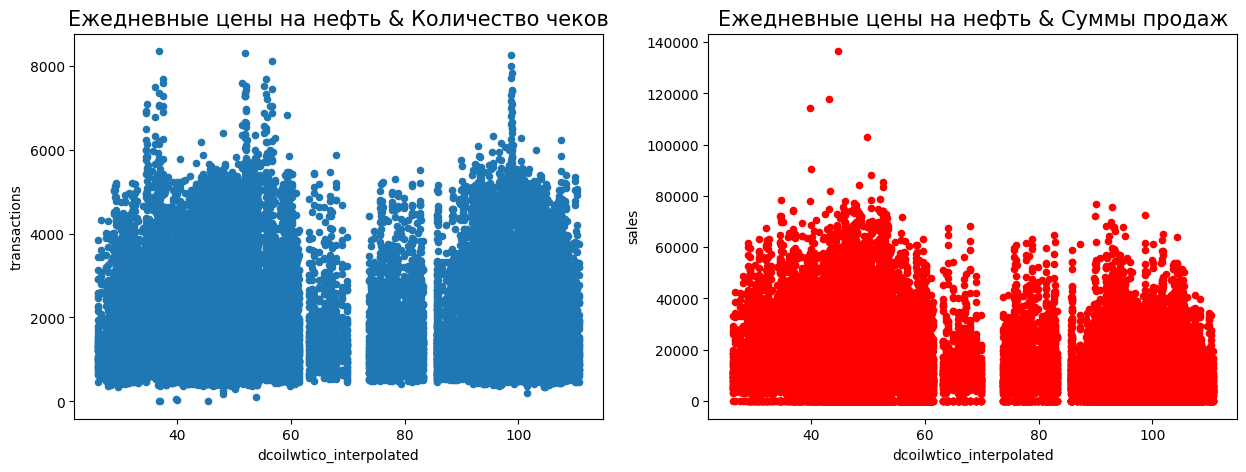

In [59]:
sv = pd.merge(sv, oil, how = "left") # сводная таблица

print("Корреляция с ценами на нефть:")
# sv.drop(["store_nbr"], axis = 1) - удалили столбец
# sv.drop(["store_nbr"], axis = 1).corr("spearman") - считаем корреляцию Спирмена
print("Sales", round(sv.drop(["store_nbr"], axis = 1).corr("spearman").dcoilwtico.loc["sales"], 2)) #- цена и продажи
print("Transactions", round(sv.drop(["store_nbr"], axis = 1).corr("spearman").dcoilwtico.loc["transactions"], 2)) #- цена и чеки

cfig, axes = plt.subplots(1, 2, figsize = (15,5))
sv.plot.scatter(x = "dcoilwtico_interpolated", y = "transactions", ax=axes[0])
sv.plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[1], color = "r")
axes[0].set_title('Ежедневные цены на нефть & Количество чеков', fontsize = 15)
axes[1].set_title('Ежедневные цены на нефть & Суммы продаж', fontsize = 15);

### **Мини-выводы (часть 2):**
* При поверхностном исследовании, зависимость экономики Эквадора от экспорта нефть ***НЕ выявлена***.

## Рисунок 3 - Цены на нефть

Давайте посмотрим, как выглядит график изменения цен на нефть)

In [60]:
p = oil.melt(id_vars=['date']+list(oil.keys()[5:]), var_name='Legend')
px.line(p.sort_values(["Legend", "date"], ascending = [False, True]), x='date', y='value', color='Legend',title = "Ежедневные цены на нефть" )

## Рисунок 4 - Корреляции таргета и действительных переменных

In [61]:
x = temp[['sales', 'transactions', 'onpromotion', 'oilprice', 'temp', 'humidity', 'windspeed(mph)', 'pressure(mbar)', 'precip']]
x.corr()

,sales,transactions,onpromotion,oilprice,temp,humidity,windspeed(mph),pressure(mbar),precip
sales,1.000000,0.837643,0.309449,-0.240261,-0.232665,0.103345,-0.226881,0.172374,-0.009537
transactions,0.837643,1.000000,0.089100,0.025725,-0.344771,0.175841,-0.228180,0.178444,0.013002
onpromotion,0.309449,0.089100,1.000000,-0.525304,-0.016022,-0.062916,-0.133541,0.175841,-0.042670
oilprice,-0.240261,0.025725,-0.525304,1.000000,-0.033398,0.039799,0.199538,-0.066100,-0.005667
temp,-0.232665,-0.344771,-0.016022,-0.033398,1.000000,-0.417748,0.212124,-0.511269,-0.060755
humidity,0.103345,0.175841,-0.062916,0.039799,-0.417748,1.000000,-0.406050,0.029956,0.413551
windspeed(mph),-0.226881,-0.228180,-0.133541,0.199538,0.212124,-0.406050,1.000000,-0.126691,-0.315448
pressure(mbar),0.172374,0.178444,0.175841,-0.066100,-0.511269,0.029956,-0.126691,1.000000,-0.008201
precip,-0.009537,0.013002,-0.042670,-0.005667,-0.060755,0.413551,-0.315448,-0.008201,1.000000


<Axes: >

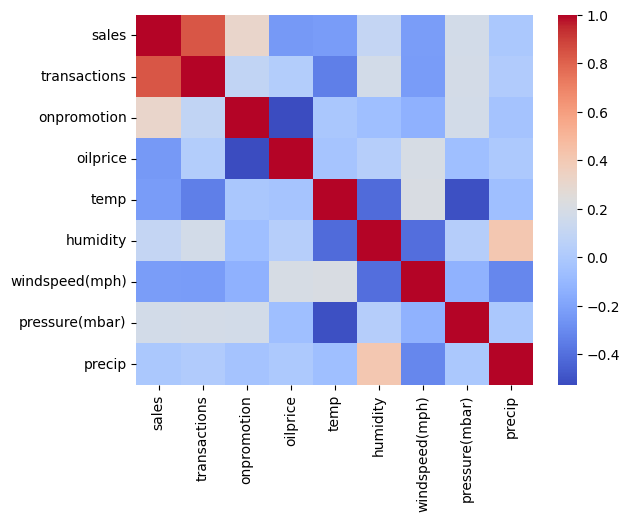

In [62]:
sns.heatmap(x.corr(), cmap= 'coolwarm')

### Мини-выводы(часть 3):
* **сильная** положительная корреляция *sales* и *transactions*;
* **слабая** положительная корреляция *sales* и *onpromotion*, *humidity* и *precip*;
* **слабая** отрицательная корреляция *onpromotion* и *oilprice*, *temp* и *pressure (mbar)*.

## Рисунок 5 - Влияние типа магазина

In [65]:
# t = temp.groupby('store_nbr').sales.mean().reset_index()
t = temp.groupby(['shop_type', 'store_nbr']).sales.mean().reset_index()

,shop_type,store_nbr,sales
0,A,44,36992.976562
1,A,45,32470.867188
2,A,46,24970.351562
3,A,47,30363.314453
4,A,48,21422.394531


A 9
B 8
C 15
D 18
E 4


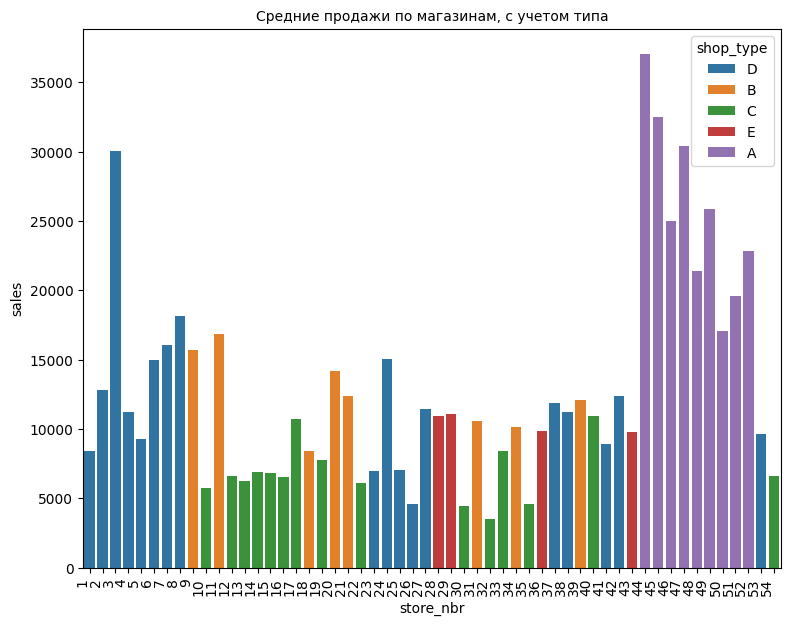

In [72]:
for i in t['shop_type'].unique():
    res = t[t['shop_type'] == i]['shop_type'].count()
    print(i, res)

fig, ax = plt.subplots(1, 1, figsize=(9,7))
sns.barplot(data = t, x = 'store_nbr', y = 'sales', hue = 'shop_type')
plt.xticks(rotation=90, ha='right')
ax.set_title('Средние продажи по магазинам, с учетом типа', fontsize=10);

### **Мини-выводы (часть 4):**
* больше всего магазинов категории *C* и *D*, меньше всего - категории *E*
* для типа *А* характерны самые высокие средние продажи; на втором месте - магазины типа *D*; ещё ниже средние продажи у *B* и *E*; самые низкие продажи у типа *C*.
* у магазина под номером "4", так же, как и у магазинов *А*, высокие средние продажи
* (среди всех типов встречаются отдельные магазины с экстремальными значениями продаж)

### **Гипотезы (часть 1)**:
* Категориальный признак 'shop_type' оказывает влияние на объем продаж (но оно несильное, т.к. категории B, D, E в среднем имеют приблизительно одинаковые показатели)
* Категориальный признак 'store_nbr' оказывает влияние на объем продаж

## Рисунок 6 - Влияние рекламы

Теперь рассмотрим вещественный признак - "onpromotion":

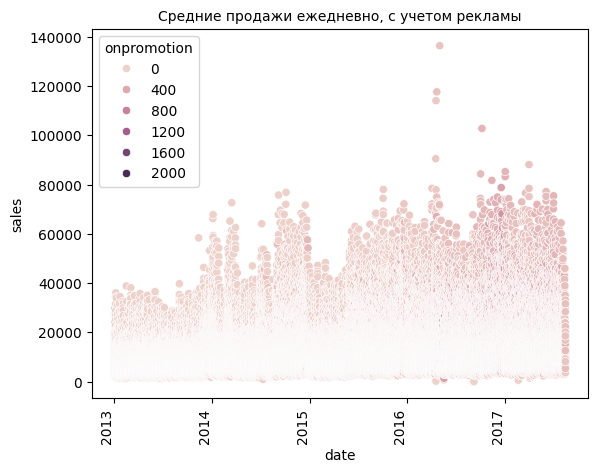

In [68]:
fig, ax = plt.subplots()
sns.scatterplot(data=temp, x='date', y='sales', hue='onpromotion')
plt.xticks(rotation=90, ha='right')
ax.set_title('Средние продажи ежедневно, с учетом рекламы', fontsize=10);

### **Мини-выводы (часть 5):**
* Высокие объемы продаж сопряжены с **не**нулевым числом рекламируемых товаров.

### **Гипотезы (часть 2):**

* Действительный признак '*onpromotion*' оказывает влияние на объем продаж.

## Рисунок 7 - Влияние праздников

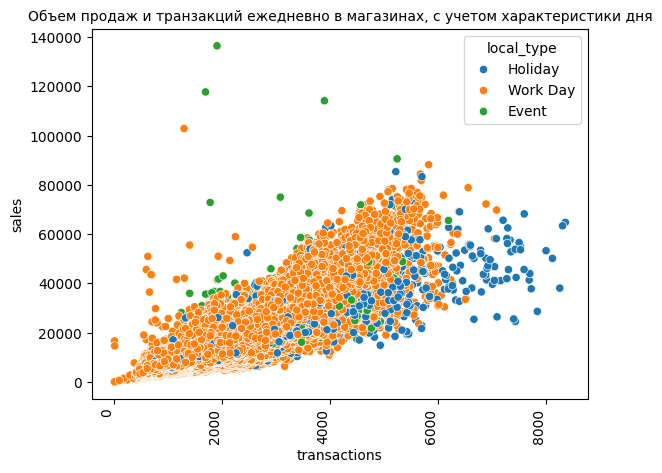

In [69]:
fig, ax = plt.subplots()
sns.scatterplot(data=temp, x='transactions', y='sales', hue='local_type')
plt.xticks(rotation=90, ha='right');
ax.set_title('Объем продаж и транзакций ежедневно в магазинах, с учетом характеристики дня', fontsize=10);

### **Мини-выводы (часть 6):**
* ***Выбросы*** по значениям *transactions* приходятся на праздничные дни (*Holiday*)
* ***Выбросы*** по значениям *sales* приходятся на дни мероприятий (*Event*).

### **Гипотезы (часть 3):**

* Категориальный признак 'local_type' оказывает влияние на объем продаж, причем значение 'Holiday' ведет скорее к увеличению *transactions*, значение 'Event' - к увеличению *sales*.

# Машинное обучение

1. В качестве target-переменной возьмём sales.
2. Так как нужно предсказать вещественные числа, будем обучать модель линейной регрессии.
3. Будем проводить масштабирование и регуляризацию
4. Для категориальных переменных используем OHE-кодирование
5. Для оценки качества модели будем использовать MSE, MAE, MAPE и др.